# Scanning Trojaned Models Using Out-of-Distribution Samples - TrojAI Benchmark

This notebook is designed to reproduce the results presented in Table 2 of the TRODO paper, focusing on Scanning Trojaned models using OOD samples. The models that are used in the experiments have been downloaded from NIST website [TrojAI Round 1 Data](https://pages.nist.gov/trojai/docs/image-classification-jun2020.html#image-classification-jun2020).

The evaluation set consists of around 1000 image classifiers, half of them backdoored and the other clean. The backdoor attack is done by training data poisoning, and different triggers have been used (dynamic trigger pattern). As TRODO does not require training data, we have combined the evaluation set for training and testing, so that a larger and more reliable evaluation set is obtained.

Full details of the evaluation set can be found at [TrojAI Round 1 Data](https://pages.nist.gov/trojai/docs/image-classification-jun2020.html#image-classification-jun2020).

A few examples of how the robustness factors manifest in the actual images used to train the AI models can be seen in the figure below, where one type of sign has been composited into several different background with a variety of transformations applied.

<p align="center">
<img src="https://pages.nist.gov/trojai/docs/images/robustness-factors-example.png" />
</p>

# Fetching code from repo

In [1]:
import os

root_name = "trodo"

if not (os.path.exists(root_name) or os.getcwd().lower().endswith(root_name)):
    !git clone https://github.com/rohban-lab/trodo

if not os.getcwd().lower().endswith(root_name):
    %cd {root_name}
!git pull

import src

Cloning into 'trodo'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 282 (delta 6), reused 12 (delta 4), pack-reused 265 (from 1)
Receiving objects: 100% (282/282), 1.32 MiB | 33.81 MiB/s, done.
Resolving deltas: 100% (146/146), done.
/content/trodo
Already up to date.


In [2]:
import numpy as np
from PIL import Image
import random
import torch
import torch.nn as nn
from copy import deepcopy
import torchvision
import copy
from torchvision import transforms
from torch.nn import functional as F
from sklearn.metrics import roc_auc_score, accuracy_score
from numpy.linalg import norm
import os
import gc
from tqdm import tqdm

In [3]:
ARCH_SPLIT = True
DEBUG = True

source_dataset = 'trojai'

augs = ['cutpaste', 'elastic', 'distort', 'jigsaw', 'gridmask', 'random_erasing']

K_AUGS = 2

# Create all possible augmentations

def create_comb(available, current_augs, k, rep=False):
    global out_dataset

    if k == 0:
        out_dataset.append(current_augs.copy())
        return
    for i, aug in enumerate(available):
        current_augs.append(aug)
        create_comb(available[:i] + available[i+1:], current_augs, k-1, rep)
        current_augs.pop()

out_dataset = []
create_comb(augs, [], K_AUGS)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
%load_ext autoreload
%autoreload 2

Using device: cuda:0


# Preparing Models


## Downloading Models from Google Drive

The following code downloads and extracts models from the [link](https://data.nist.gov/pdr/lps/ark:/88434/mds2-2195) provided by TrojAI.

First, go to this [link](https://drive.google.com/drive/folders/1sE6EErrDn_2xq1sh3xPYCzpMu50mGEPi) and create a shortcut to your google drive.

**Note**: The reason for this is that, we don't want to download all the models, which are about 1000, due to disk limitations in Google Colab free plan, and the long time that it takes to download all models. We also asked you to make a shortcut from the drive folder of models, because otherwise you would have to provide API Key, which just makes things more complicated.

In [4]:
DRIVE_ROOT = '/content/drive'
TROJAI_ROOT = DRIVE_ROOT + "/MyDrive/image-classification-jun2020-train"
models_meta = os.path.join(TROJAI_ROOT, "METADATA.csv")
TROJAI_MODELS_ROOT = os.path.join(TROJAI_ROOT, "models")
models_root = "/data/trojai_models"

In [5]:
# use this code to mount your google drive
from google.colab import drive
drive.mount(DRIVE_ROOT)

Mounted at /content/drive


**Note**: You may need to re-run this cell, if an error occured while extracting the models.

In [15]:
# This points to the TrojAI root
import os, time
from tqdm import tqdm

# Extract
!mkdir -p {models_root}


# Due to limitations of Google Colab's Disk and for faster execution, we have limited the models
MODELS_LIMIT = 0.1
all_folders = os.listdir(TROJAI_MODELS_ROOT)
target_folders = all_folders[:int(MODELS_LIMIT * len(all_folders))]

with tqdm(enumerate(target_folders)) as tq:
  for i, file in tq:
      if file.endswith(".tar.gz"):
          file_path = os.path.join(TROJAI_MODELS_ROOT, file)
          !cp {file_path} {models_root}/{file}
          !tar -xf {models_root}/{file} -C {models_root}
          !rm {models_root}/{file}
          time.sleep(10)

print("Total no. models:", len(os.listdir(models_root)))

10it [07:35, 45.51s/it]

Total no. models: 96


**Note**: You can download the models by any other way as you wish. You only have to set the `models_root` and `models_meta` variables accordingly.

## Loading models


In [16]:
from src.trojai.model_dataset import TrojAIDataset as ModelDataset
from src.trojai.utils import load_model, split_dataset_by_arch
# models root and models data have been set in one of previous ways to load trojai models

def prepare_dataset(dataset):
    if ARCH_SPLIT:
        return split_dataset_by_arch(dataset)
    else:
        return {'all_archs': dataset}

def get_length(dataset):
    return sum([len(x) for _, x in dataset.items()])

modelset = prepare_dataset(ModelDataset(models_root,
                                        rnd=1,
                                        model_loader=load_model,
                                        custom_arch=None,
                                        data_csv=models_meta))

print("Length of modelset", get_length(modelset))

Length of modelset 96


In [17]:
all_archs = list(modelset.keys())
print("All groups:")
print(all_archs)

All groups:
['densenet121', 'resnet50', 'inceptionv3']


In [18]:
def param_count(model):
    return sum([p.numel() for p in model.parameters()])

params_count = {}
for arch in all_archs:
    model = modelset[arch][0][0]
    if model is None:
        continue

    params_count[arch] = param_count(model)

all_archs = sorted(all_archs, key=lambda arch: params_count[arch])

for arch in all_archs:
    print(f"{arch}: {params_count[arch] / 1e6}")

Loading a densenet121
Loading a resnet50
Loading a inceptionv3
densenet121: 6.958981
resnet50: 23.518277
inceptionv3: 24.357354


## Sanity Checks

In [19]:
def get_sample_model():
    rand_arch = random.sample(list(modelset.keys()), 1)[0]
    rand_dataset = modelset[rand_arch]
    sample_model, _ = rand_dataset[random.randint(0, len(rand_dataset) - 1)]
    return sample_model

## CLS Loader

In [20]:
from torch.utils.data import Subset
from src.trojai.utils import get_oodloader_trojai


def get_dataloader(model, verbose=False, only_ood=True):
    dataloader = get_oodloader_trojai(model,
                                      out_dataset,
                                      only_ood=only_ood,
                                      dummy_params = {'size': 224},
                                      verbose=verbose)
    if verbose:
        print("Size of dataset:", len(dataloader.dataset))
    return dataloader

next(iter(get_dataloader(get_sample_model(), verbose=True)))
pass

Loading a densenet121
Loading a dataset with 5 classes
Size of dataset: 500


In [21]:
def get_msp(model, data):
    logits = model(data)
    probs = torch.softmax(logits, dim=1)
    scores, _ = torch.max(probs, dim=1)
    return scores

def mean_id_score(model,
                   dataloader,
                   device=None):

    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    id_scores = []

    for data, targets in dataloader:
        data = data.to(device)
        # display(data)
        id_scores += get_msp(model, data).detach().cpu().numpy().tolist()

        torch.cuda.empty_cache()
        gc.collect()

    id_scores = np.asarray(id_scores)

    return np.mean(id_scores)

# sample_model = get_sample_model()
sample_model, _ = modelset['densenet121'][0]
print("Mean ID Score for OOD Dataset:", mean_id_score(sample_model, get_dataloader(sample_model, verbose=True)))
del sample_model

Loading a densenet121
Loading a dataset with 5 classes
Size of dataset: 500
Mean ID Score for OOD Dataset: 0.9116989325284958


Loading a densenet121
Loading a dataset with 5 classes
Size of dataset: 1000


<Figure size 640x480 with 0 Axes>

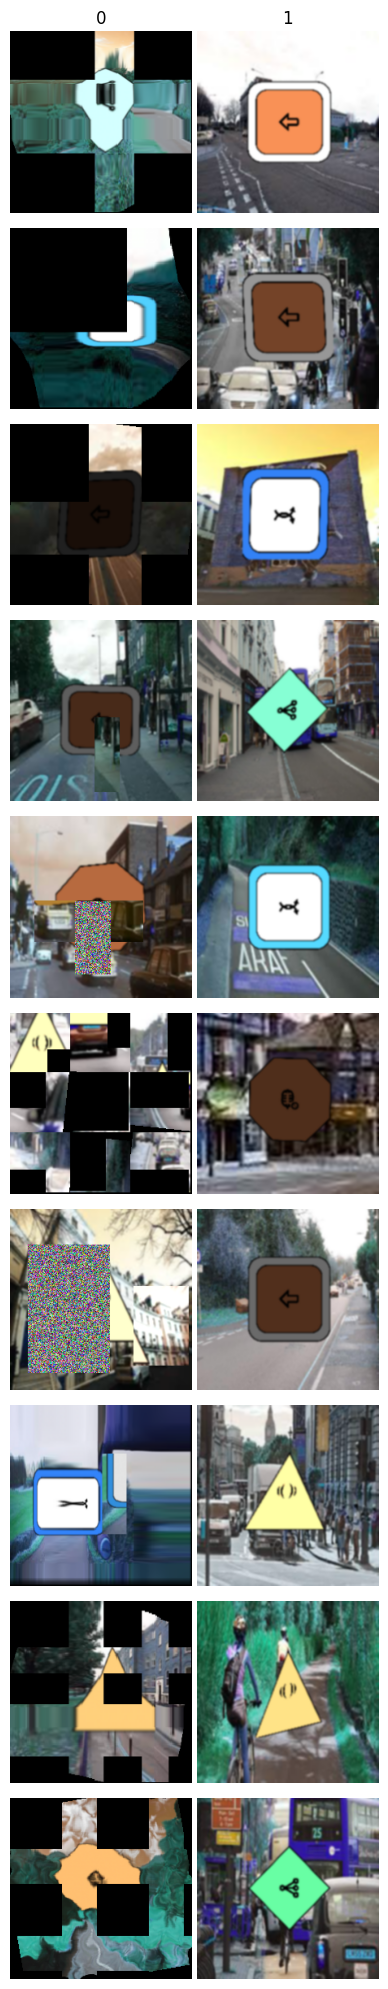

<Figure size 640x480 with 0 Axes>

In [22]:
from src.visualization import visualize_samples

visualize_samples(get_dataloader(get_sample_model(), verbose=True, only_ood=False), 10)

# Experiments

Note that we use AUROC, as it is the metric that is used in TrojAI leaderboard

Working on densenet121 model 1/32
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.9188129564523697
After: 0.987577226638794
0 0.06876427018642428
Working on densenet121 model 2/32
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.8403622498512268
After: 0.9867188678979874
1 0.1463566180467606
Current AUC: 1.0
Working on densenet121 model 3/32
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.929816757619381
After: 0.9970491716861725
0 0.06723241406679148
Current AUC: 1.0
Working on densenet121 model 4/32
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.928922338783741
After: 0.997116662144661
1 0.06819432336092002
Current AUC: 0.75
Working on densenet121 model 5/32
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.9183151929974556
After: 0.9957257205247879
0 0.07741052752733235
Current AUC: 0.6666666666666667
Working on densenet121 model 6/32
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.83

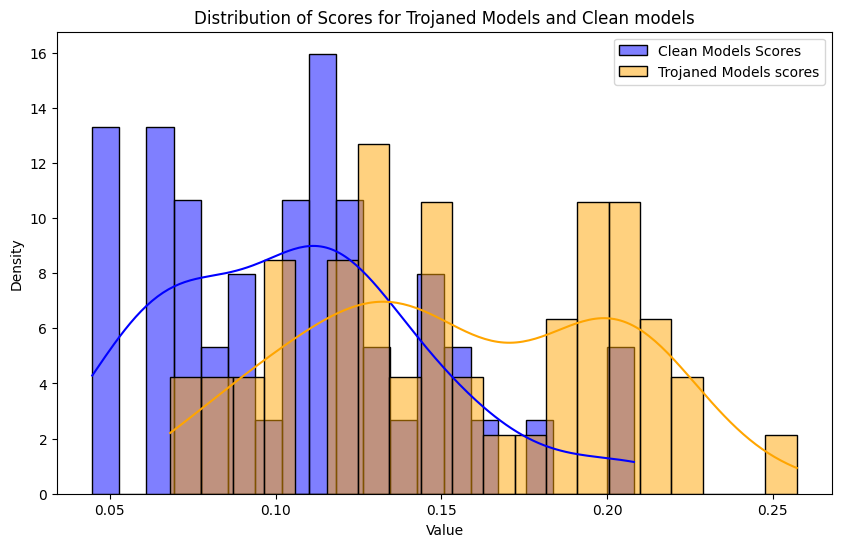

Total number of failed models: 0
Average weighted auroc across all groups: 0.7853064963359081
Average normal auroc across all groups: 0.7813043478260869


In [23]:
from tqdm import tqdm
import random
from src.evaluate import evaluate_modelset, mean_id_score_diff
from src.visualization import draw_dists
Aucs = {}

no_failed = 0

bad_scores = []
good_scores = []

LIMIT = 100

all_labels = []
all_scores = []

for arch in all_archs:

    try:
        arch_modelset = modelset[arch]
        labels = []
        scores = []
        cnt = len(arch_modelset)
        for i in range(cnt):
            print(f"Working on {arch} model {i+1}/{cnt}")
            try:
                model, label = arch_modelset[i]


                dataloader = get_dataloader(model)

                score = mean_id_score_diff(model, dataloader, verbose=True, eps=2/255)
                del model


                if label == 0:
                    good_scores.append(score)
                else:
                    bad_scores.append(score)

                labels.append(label)
                scores.append(score)
                print(label, score)
                if 0 in labels and 1 in labels:
                    print(f"Current AUC: {roc_auc_score(labels, scores)}")
            except Exception as e:
                print("An error occured while loading a", arch, "model")
                print("Error:", str(e))
                no_failed += 1

                continue
        all_labels += labels
        all_scores += scores
        final_auc = roc_auc_score(labels, scores)
        print(f"Final AUROC on test set for group {arch}: {final_auc}")
        Aucs[arch] = final_auc
    except Exception as e:
        print("An error on saving results for ", arch, "models")
        print("Error:", str(e))

draw_dists(good_scores, bad_scores)

print("Total number of failed models:", no_failed)

# weighted_mean_acc = 0
weighted_mean_auc = 0
all_cnt = 0
for arch in Aucs.keys():
    cnt = len(modelset[arch])
    # weighted_mean_acc += cnt * Accs[arch]
    weighted_mean_auc += cnt * Aucs[arch]
    all_cnt += cnt
print("Average weighted auroc across all groups:", weighted_mean_auc / all_cnt)
print("Average normal auroc across all groups:", roc_auc_score(all_labels, all_scores))